# Traveling Salesman on Dirac
#### Device: Dirac-1

## Introduction

The traveling salesman problem (TSP) is a longstanding example of the difficulty found in solving combinatorial problems. The typical problem statement is that a list of cities must all be visited, but one can do so in any order. A list of distances between cities is provided, and the goal is to find the order that minimizes the total distance traveled. Despite the simple explanation of the problem, a polynomial-time solution is not known to exist. This example takes 8 random points on the upper right quadrant $(30, 30)$ of the Cartesian plane, calculates the Euclidian distance between them, and formulates a sequential model (visit node $x_i$ first, node $x_j$ second and so forth ).

## Importance

TSP is often used as an archetypal example of a hard optimization problem. It is easy to understand how such a problem arises, the statement is simple and non-technical, and the constraints are easy to understand. Sometimes people even informally use it as a shorthand for all hard combinatorial optimization problems, referring to NP-hard problems as "travelling salesman type problems". When formally stating the constraints of the TSP, the best formulation is not to directly constrain "visit each city at least once". Instead, the constraints are formally that $n$ cities have to be visited, and each can be visited only once. Since distances between cities are positive, returning to the same city multiple times is clearly suboptimal, and therefore such routes do not need to be included among the possibilities. Note that it is perfectly possible that the shortest route goes through another city, but this case does not need any special treatment. The second constraint is one which is physically obvious but still needs to be explicitly encoded: the salesperson can only be in once city at a time. The constraint structure is therefore what is called a two-way one-hot structure. Variables correspond to visiting a city at a certain time in the tour, if we arrange these in rows corresponding to cities and columns corresponding to times, the sum of each row and column must be one. Since it involves constraints, we format the TSP as a [quadratic linearly constrained binary optimization](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qlcbo-on-dirac) problem. This constraint pattern can be found in other problems as well, for example the [quadratic assignment problem](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quadratic-assignment-on-dirac).

## Applications
The most obvious application of this problem can be deduced from the name. Imagine a door-to-door salesperson who has to visit a set of cities to sell goods. The order is not important, but every city must be visited. However, the salesperson has to buy fuel and spend time driving, so they want to minimize the distance. This stereotypical application has even made it into popular culture, for example, in [xkcd 399](https://xkcd.com/399). One can also imagine many situations in logistics where the same problem could arise. For example, if a driver were making deliveries or picking items up instead of selling products. Less obvious examples are summarized in [this book](https://core.ac.uk/download/478116421.pdf). For example, this problem can also arise in manufacturing, when holes must be drilled in a board, but can be done so in any order. Similarly, if a circuit is to be wired with connected pins, but only two wires are allowed to connect to each. A completely different example comes up in x-ray crystallography where a single sensor must be moved to measure at different places, but the measurements can be taken in any order.

## Using Dirac-1 Through the Cloud

### I. Imports

These imports bring in various libraries and modules for different functionalities, such as: 
- `os.path`: Provides functions for working with file paths.
- `numpy as np`: Numerical computing library for arrays and mathematical operations.
- `matplotlib.pyplot as plt`: Plotting library for creating visualizations.
- `Dirac1CloudSolver` from `eqc_models.solvers`: Client class for interacting with an external service.
- `QAPModel` from `eqc_models.assignment`: Class for quadratic assignment problem models

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from eqc_models.solvers import Dirac1CloudSolver
from eqc_models.assignment import QAPModel

### II. Plot of random points

- Visualize the set up of the initial conditions for solving the TSP by generating city coordinates.

In [2]:
n = 8
np.random.seed(n)
coords = np.random.randint(1, 30, (n, 2))

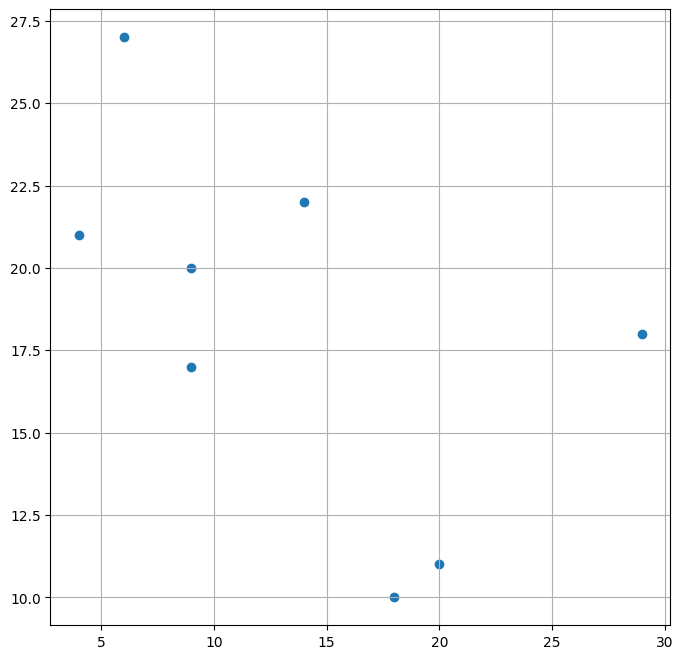

In [3]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(coords[:,0], coords[:, 1])
plt.grid()

### III. Problem formulation

`tsp_objective`, below, computes the components of the objective function for the Traveling Salesman Problem (TSP) based on the given distance matrix. The components are components of quadratic assignment problems, tailored towards TSP.

- Input: `distance_matrix` is a square matrix representing the distances between various locations (nodes) in the TSP.

- Output: The function returns three components of the TSP objective function:

    1. Distance Matrix (`D`): This matrix represents the distances between locations. It's essentially a copy of the input `distance_matrix`.

    2. Flow Matrix (`flow`): This matrix represents the flow or connections between locations. It's a diagonal matrix with ones along the secondary diagonal and one additional one to close the loop (from the last node back to the first).

    3. Fixed Cost Matrix (`fixed_cost`): This matrix represents fixed costs associated with visiting each location. The first row indicates the fixed cost for each location, and it's set to 4 for all locations except the first (which is set to 0). The values are then normalized so that their sum equals the average cost per location.
    
These components are used to formulate the objective function for optimization algorithms solving the TSP.

In [4]:
def tsp_objective(distance_matrix):
    n = distance_matrix.shape[0]
    D = distance_matrix
    flow = np.diag(np.ones(n-1), 1)
    flow[n-1, 0] = 1
    fixed_cost = np.zeros((n, n))
    fixed_cost[0, :] = 4 * np.ones(n)
    fixed_cost[0, 0] = 0.0
    fixed_cost /= (np.sum(fixed_cost) / n)
    return D, flow, fixed_cost

Compute the pairwise distances between each pair of coordinates to be used in the problem instance.

In [5]:
def dist(coord1, coord2):
    return np.sqrt(np.sum(np.power(coord1-coord2, 2), axis=1))

distance_matrix = np.zeros((n, n))
for i in range(n):
    distance_matrix[i,:] = dist(coords, coords[i])

After constructing the necessary data structures QAP needs for the TSP, create a model instance.

In [6]:
A, B, C = tsp_objective(distance_matrix)
qapmodel = QAPModel(A, B, C)

### IV. Obtain a Solver Client
The `Dirac1CloudSolver` class is used to manage access to the cloud service for running jobs on Dirac-1. The constructor accepts two parameters

- `url` which is the same as the QCI_API_URL environment variable for `QciClient`
- `api_token` which is same as the QCI_TOKEN environment variable for `QciClient`

If these variables are not supplied, the shell environment is used for client configuration. This is the preferred method and is used here. Once the solver is instantiated, it can be used to solve any subclass of `eqc_models.base.EQCModel` that provides the `qubo` operator.

In [7]:
solver = Dirac1CloudSolver()

**Solve**

Model parameters:
- `penalty_multiplier`: 20

Method parameters:
- `num_samples`: 5


In [8]:
qapmodel.penalty_multiplier = 20
response = solver.solve(qapmodel, num_samples=5)

2025-01-07 11:04:57 - Dirac allocation balance = 0 s (unmetered)
2025-01-07 11:04:57 - Job submitted: job_id='677d6cc98dd54d8a9ea605ec'
2025-01-07 11:04:57 - QUEUED
2025-01-07 11:04:59 - RUNNING
2025-01-07 11:06:04 - COMPLETED
2025-01-07 11:06:07 - Dirac allocation balance = 0 s (unmetered)


In [9]:
results = response["results"]
results

{'counts': [1, 1, 1, 1, 1],
 'energies': [-254.43588545796047,
  -252.56479170796047,
  -251.30307295796047,
  -249.74154952046047,
  -247.97543623921047],
 'solutions': [[0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
 

### V. Evaluate solution

Visualization of a route based on a given solution to the Traveling Salesman Problem (TSP).

In [10]:
def plot_route(coords, solution, N):
    pairs = []
    order = [None for i in range(N)]
    for i in range(N):
        for j in range(N):
            if solution[i*N + j] == 1:
                order[j] = i
    for i in range(N):
        u = order[i-1]
        v = order[i]
        if u is None or v is None:
            continue
        pt1 = coords[u, :]
        pt2 = coords[v, :]
        x = [pt1[0], pt2[0]]
        y = [pt1[1], pt2[1]]
        plt.plot(x, y, "r-")
    plt.scatter(coords[:,0], coords[:, 1], c="k", marker="o")

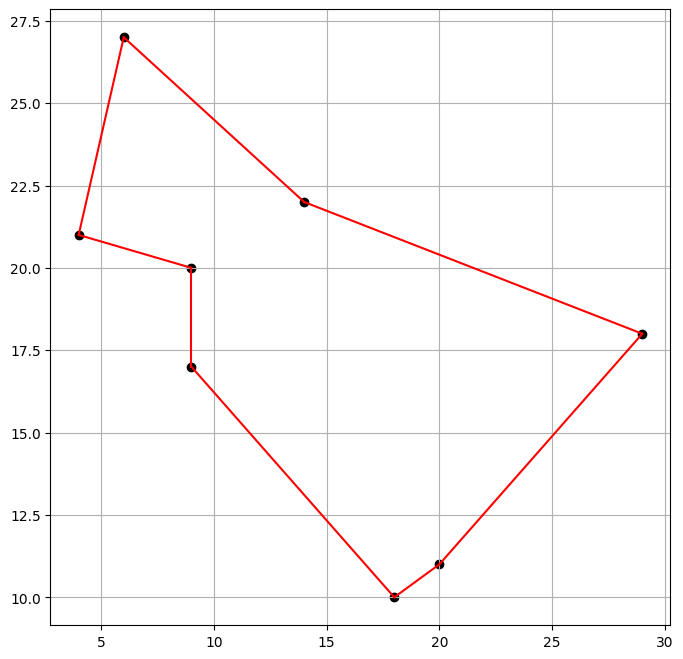

In [11]:
fig = plt.figure(figsize=(8, 8))
plot_route(coords, results["solutions"][0], n)
plt.grid()

## Conclusion

In this tutorial, we have shown how to use QCi hardware for one of the most well known NP-hard optimization problems, the traveling salesman problem. We constructed a simple map that assumes travel in a straight line between randomly assigned cities, and have visualized the result. A good next step could be to look at the [quadratic assignment problem](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quadratic-assignment-on-dirac), which uses the same constraint structure. Of course, another option is to start using our device to solve some of your own optimization problems.